In [2]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage import morphology, filters
from skimage import io
import os.path
from os import path
from tensorflow import keras
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from datetime import timedelta
import convolutional
def processing_image(directory):
    img = cv2.imread(directory)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m,n =  img.shape

    img_new = np.zeros([m, n]) 

    for i in range(1, m-1): 
        for j in range(1, n-1): 
            temp = [img[i-1, j-1], 
                img[i-1, j], 
                img[i-1, j + 1], 
                img[i, j-1], 
                img[i, j], 
                img[i, j + 1], 
                img[i + 1, j-1], 
                img[i + 1, j], 
                img[i + 1, j + 1]] 
            
            temp = sorted(temp) 
            img_new[i, j]= temp[4] 
    
    img_new = img_new.astype(np.uint8) 
    img_new = cv2.equalizeHist(img_new)

    image = invert(img_new,0)

    img = image.copy()
    skel = img.copy()
    skel[:,:] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
    iterations = 0

    while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]
        if cv2.countNonZero(img) == 0:
            break
    ret, thr = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY)
    thr = cv2.resize(thr,(64,48))
    
    #cv2.imshow(directory,thr) 
    #cv2.waitKey(0)
    thr = thr.reshape(1,48*64)
    return thr
def extractdatabase(LeftOrRight,MaleOrFemale,numberofseries):
    trainx = np.array([], dtype=np.int64).reshape(0, 3072)
    trainy = np.array([], dtype=np.int64).reshape(0, 312)
    testx = np.array([], dtype=np.int64).reshape(0, 3072)
    testy = np.array([], dtype=np.int64).reshape(0, 312)

    for i in range(1, 313):
        subject = str(i).zfill(4)
        b = np.zeros(312)
        b[int(subject)-1]=1
        b = b.reshape(1, 312)
        if LeftOrRight == 'Left':
            LoR = 'l'
        elif LeftOrRight == 'Right':
            LoR = 'r'
        if MaleOrFemale == 'Male':
            MoF = 'm'
        elif MaleOrFemale == 'Female':
            MoF = 'f'
        dic = 'D:\\dataset\\' + subject + '\\' + subject + '_' + MoF + '_' + LoR + '_' + '01' + '.jpg'
        if path.exists(dic) == False:
            continue
        c = b
        a = processing_image(dic)
        
        for j in range(2, numberofseries + 1):
            dic = dic[:26] + str(j) + '.jpg'
            if path.exists(dic) == False:
                continue
            x = processing_image(dic)
            a = np.concatenate((a, x))
            c = np.concatenate((c, b))
        trainx = np.vstack([trainx, a])
        trainy = np.vstack([trainy, c])
        
        test_b = b
        dic = 'D:\\dataset\\' + subject + '\\' + subject + '_' + MoF + '_' + LoR + '_' + '0' + str(numberofseries+1) + '.jpg'
        if path.exists(dic) == False:
            continue
        test_a = processing_image(dic)
        trainingSeries = 7 - numberofseries
        for k in reversed(range(9-trainingSeries,9)):
            dic = dic[:26] + str(k) + '.jpg'
            if path.exists(dic) == False:
                continue
            x = processing_image(dic)
            test_a = np.concatenate((test_a,x))
            test_b = np.concatenate((test_b,b))
        
        testx=np.vstack([testx,test_a])
        testy=np.vstack([testy,test_b])
    
    return trainx,trainy,testx,testy

In [2]:
trainx, trainy, testx, testy = extractdatabase('Left','Male',7)

In [3]:
x = processing_image('D:\\dataset\\0001\\0001_m_l_01.jpg')

In [4]:
print(x.shape)

(1, 3072)


In [3]:
ide=10
# Convolutional Layer 1.
filter_size1=5                  # Convolution filters are 5x5
num_filters1=36                 # We have 16 of these filters

# Convolutional Layer 2.
filter_size2=3                  # Convolution filters are 5x5
num_filters2=36                 # We have 36 of these filters

# Multilayer perceptron
fc_size= 128   


In [4]:
def getnewbatch(iteraction):
    global batch_iterations
    miniX=trainx[(25*batch_iterations):(25+(25*batch_iterations))]
    miniY=BtrainY[(25*batch_iterations):(25+(25*batch_iterations))]
    batch_iterations+=1
    if batch_iterations == 16:
        batch_iterations=0
    return miniX,miniY

In [5]:
def  plot_images (images, cls_true, cls_pred=None):
#    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [6]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = testx[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = testy[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


In [7]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch,y_true_batch= getnewbatch(total_iterations)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)


        # Print status every 100 iterations.
        if i % 20 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
            print_test_accuracy()
    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


In [11]:
test_batch_size = 25
def print_test_accuracy(show_example_errors=False):

    # Number of images in the test-set.
    num_test = len(testx)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = testx[i:j, :]

        # Get the associated labels.
        labels = BtrainY[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
    
    # Convenience variable for the true class-numbers of the test-set.
    cls_true =np.zeros(num_test,np.int8)
    for i in range(0,len(BtestY)):
        cls_true[i] = np.argmax(BtestY[i])
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
#    print(correct)
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = sum(1 for a, b in zip(cls_pred, cls_true) if a == b)
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
#

In [12]:
def binary(identity,testY,trainY):
    BtestY=np.zeros([len(testY),2])
    BtrainY=np.zeros([len(trainY),2])
    for i in range(0,len(testY)):
        if testY[i,identity]==1:
            BtestY[i,0]=1
        else:
            BtestY[i,1]=1
    for ii in range(0,len(trainY)):
        if trainY[ii,identity]==1:
            BtrainY[ii,0]=1
        else:
            BtrainY[ii,1]=1
    return BtestY, BtrainY
BtestY,BtrainY=binary(9,testy,trainy)

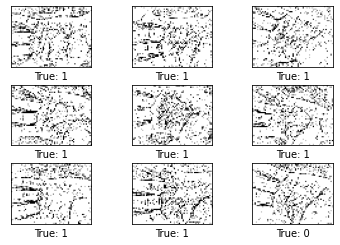

In [13]:
img_size = 28
img_size_flat = len(testx[0])
img_shape = (48,64)
num_channels = 1
num_classes = 2
images = testx[0:9]
cls_true = np.argwhere(BtestY[0:9])[:,1]
plot_images(images=images, cls_true=cls_true)

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, 48, 64, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)  
layer_conv1, weights_conv1 = \
    convolutional.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    convolutional.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_flat, num_features = convolutional.flatten_layer(layer_conv2)
layer_fc1 = convolutional.new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = convolutional.new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer  = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

#   Batch size will be constant to 25

# Counter for total number of iterations performed so far.
total_iterations = 0
batch_iterations = 0

##############################################
optimize(num_iterations=1000)

Optimization Iteration:      1, Training Accuracy: 100.0%
Accuracy on Test-Set: 99.1% (230 / 232)
<ipython-input-11-991eabdbc46a>:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = (cls_true == cls_pred)
Optimization Iteration:     21, Training Accuracy:  96.0%
Accuracy on Test-Set: 91.4% (212 / 232)
Optimization Iteration:     41, Training Accuracy: 100.0%
Accuracy on Test-Set: 89.2% (207 / 232)
Optimization Iteration:     61, Training Accuracy: 100.0%
Accuracy on Test-Set: 99.1% (230 / 232)
Optimization Iteration:     81, Training Accuracy: 100.0%
Accuracy on Test-Set: 99.6% (231 / 232)
Optimization Iteration:    101, Training Accuracy: 100.0%
Accuracy on Test-Set: 98.3% (228 / 232)
Optimization Iteration:    121, Training Accuracy: 100.0%
Accuracy on Test-Set: 99.1% (230 / 232)
Optimization Iteration:    141, Training Accuracy: 100.0%
Accuracy on Test-Set: 99.6% (231 / 232)
Optimization Iteration:    161, Training Accuracy: 100